# Portfolio Risk Management Analysis
This notebook performs comprehensive risk analysis for a stock portfolio including:

#### CAPM ratios (Sharpe, Treynor, Information Ratio)
#### Value at Risk (VaR) and Conditional Value at Risk (CVaR)
#### Monte Carlo simulation for price prediction
#### Portfolio optimization and performance metrics

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from adjustText import adjust_text
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette("husl")

# Configuration and Portfolio Setup

In [5]:
# Portfolio Configuration in DOLLAR VALUES
PORTFOLIO_DOLLARS = {
    'NVDA': 25000,   # Nvidia - $25,000
    'PYPL': 25000,   # Paypal - $25,000
    'BAC': 20000,  # Bank oF America - $20,000
    'KO': 20000,   # Coca-Cola - $20,000
    'JPM': 10000   # JP Morgan - $10,000
}

# Calculate total portfolio value
TOTAL_PORTFOLIO_VALUE = sum(PORTFOLIO_DOLLARS.values())

# Convert dollar values to weights (percentages)
PORTFOLIO = {stock: value/TOTAL_PORTFOLIO_VALUE
             for stock, value in PORTFOLIO_DOLLARS.items()}

# Market benchmark
MARKET_SYMBOL = 'SPY'  # S&P 500 ETF as market proxy

# Analysis Parameters (keep these the same)
RISK_FREE_RATE = 0.05  # 5% annual risk-free rate
CONFIDENCE_LEVELS = [0.95, 0.99]  # For VaR and CVaR calculations
TRADING_DAYS = 252  # Number of trading days in a year

# Monte Carlo Parameters (keep these the same)
MC_SIMULATIONS = 10000
MC_TIME_HORIZON = 252  # 1 year forecast

# Data Parameters (keep these the same)
START_DATE = '2017-01-01'
END_DATE = '2025-07-01'

# Validation periods for robustness testing
VALIDATION_PERIODS = {
    'Pre-COVID': ('2017-01-01', '2019-12-31'),
    'COVID-Recovery': ('2020-01-01', '2022-12-31'),
    'Post-Normalization': ('2023-01-01', '2025-07-01'),
    'Full-Period': ('2017-01-01', '2025-07-01')
}

print(f"\n📊 ANALYSIS CONFIGURATION")
print(f"Main Analysis Period: {START_DATE} to {END_DATE}")
print(f"Total Duration: ~{(pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days / 365.25:.1f} years")


📊 ANALYSIS CONFIGURATION
Main Analysis Period: 2017-01-01 to 2025-07-01
Total Duration: ~8.5 years


# Data Acquisition Using yfinance


In [6]:
# Note: If yfinance is experiencing issues, see the alternative in the next cell
print("Fetching data using yfinance...")

# Combine portfolio stocks with market benchmark
all_symbols = list(PORTFOLIO.keys()) + [MARKET_SYMBOL]

# Download all data at once
stock_data = yf.download(all_symbols, start=START_DATE, end=END_DATE, progress=True)

# Extract closing prices
closing_prices = stock_data['Close'] if len(all_symbols) > 1 else pd.DataFrame({all_symbols[0]: stock_data['Close']})

print(f"\nData shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")

# Verify data quality and coverage
total_trading_days = len(closing_prices)
expected_days = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
coverage_ratio = total_trading_days / (expected_days * 0.7)  # ~70% accounting for weekends/holidays

print(f"Data Quality Check:")
print(f"  Total trading days: {total_trading_days}")
print(f"  Expected coverage: {coverage_ratio:.1%}")
print(f"  Data density: {'✅ Good' if coverage_ratio > 0.9 else '⚠️ Check data gaps'}")

Fetching data using yfinance...


[*********************100%***********************]  6 of 6 completed


Data shape: (2134, 6)
Date range: 2017-01-03 00:00:00 to 2025-06-30 00:00:00
Data Quality Check:
  Total trading days: 2134
  Expected coverage: 98.2%
  Data density: ✅ Good


# Data Preprocessing and Returns Calculation

In [7]:
# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Separate portfolio and market returns
portfolio_returns = returns[list(PORTFOLIO.keys())]
market_returns = returns[MARKET_SYMBOL]

# Display basic statistics
print("Daily Returns Statistics:")
print(returns.describe())

# === DIAGNOSTIC : Impact Extended Period ===
print(f"\n🔍 IMPACT ANALYSIS - Extended Period")
print(f"New dataset shape: {returns.shape}")
print(f"New date range: {returns.index[0].date()} → {returns.index[-1].date()}")

# Compare key statistics
recent_period = returns.loc['2022-01-01':]
full_period = returns

print(f"\nSTATISTICAL COMPARISON:")
print(f"{'Metric':<20} {'Recent (2022+)':<15} {'Full Period':<15} {'Difference':<15}")
print("-" * 65)

for col in portfolio_returns.columns:
    recent_vol = recent_period[col].std() * np.sqrt(252)
    full_vol = full_period[col].std() * np.sqrt(252)

    print(f"{col:<20} {recent_vol:<15.1%} {full_vol:<15.1%} {(full_vol-recent_vol):<15.1%}")

Daily Returns Statistics:
Ticker          BAC          JPM           KO         NVDA         PYPL  \
count   2133.000000  2133.000000  2133.000000  2133.000000  2133.000000   
mean       0.000637     0.000831     0.000442     0.002459     0.000599   
std        0.019944     0.017841     0.011742     0.032153     0.024829   
min       -0.153973    -0.149649    -0.096725    -0.187559    -0.245904   
25%       -0.008889    -0.007340    -0.004809    -0.014468    -0.011505   
50%        0.000370     0.000670     0.000719     0.002800     0.001501   
75%        0.010293     0.009073     0.005993     0.019570     0.012892   
max        0.177962     0.180125     0.064796     0.243696     0.141098   

Ticker          SPY  
count   2133.000000  
mean       0.000609  
std        0.011872  
min       -0.109424  
25%       -0.003709  
50%        0.000740  
75%        0.006212  
max        0.105019  

🔍 IMPACT ANALYSIS - Extended Period
New dataset shape: (2133, 6)
New date range: 2017-01-04 → 2025-

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Portfolio Performance Metrics


In [8]:
# Calculate portfolio returns based on weights
weights = np.array(list(PORTFOLIO.values()))
portfolio_return_series = (portfolio_returns * weights).sum(axis=1)

# Basic statistics
annualized_return = portfolio_return_series.mean() * TRADING_DAYS
annualized_volatility = portfolio_return_series.std() * np.sqrt(TRADING_DAYS)
downside_returns = portfolio_return_series[portfolio_return_series < 0]
downside_volatility = downside_returns.std() * np.sqrt(TRADING_DAYS)

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Downside Volatility: {downside_volatility:.2%}")

Portfolio Performance Metrics:
Annualized Return: 26.79%
Annualized Volatility: 26.30%
Downside Volatility: 19.86%


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Statistical Validation

In [9]:
# ==========================================================================
# STATISTICAL VALIDATION & ASSUMPTIONS TESTING
# ==========================================================================

print("\n" + "=" * 80)
print("📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS")
print("=" * 80)


def comprehensive_statistical_tests(returns_series, name="Portfolio"):
    """
    Comprehensive statistical testing for financial time series
    """
    results = {}
    clean_returns = returns_series.dropna()

    # 1. NORMALITY TESTS
    # Jarque-Bera Test (most common in finance)
    jb_stat, jb_pvalue = stats.jarque_bera(clean_returns)

    # Shapiro-Wilk Test (more powerful for smaller samples)
    if len(clean_returns) <= 5000:  # Shapiro limited to 5000 obs
        sw_stat, sw_pvalue = stats.shapiro(clean_returns[:5000])
    else:
        sw_stat, sw_pvalue = None, None

    # 2. AUTOCORRELATION TESTS - VERSION ROBUSTE
    try:
        lb_result = acorr_ljungbox(clean_returns, lags=10, return_df=True)
        if len(lb_result) > 0:
            # Take the 10th lag
            lb_stat = lb_result['lb_stat'].iloc[-1]
            lb_pvalue = lb_result['lb_pvalue'].iloc[-1]
        else:
            lb_stat, lb_pvalue = 0.0, 1.0
    except Exception as e:
        print(f"⚠️ Warning: Ljung-Box test failed for {name}: {e}")
        lb_stat, lb_pvalue = 0.0, 1.0

    # 3. STATIONARITY TEST
    try:
        adf_stat, adf_pvalue, _, _, adf_critical, _ = adfuller(clean_returns)
    except Exception as e:
        print(f"⚠️ Warning: ADF test failed for {name}: {e}")
        adf_stat, adf_pvalue = 0.0, 0.01  # Assume stationary

    # 4. DISTRIBUTION CHARACTERISTICS
    skewness = stats.skew(clean_returns)
    kurtosis = stats.kurtosis(clean_returns, fisher=True)  # Excess kurtosis

    # Store results
    results = {
        'name': name,
        'observations': len(clean_returns),
        'jarque_bera': {'statistic': jb_stat, 'p_value': jb_pvalue},
        'shapiro_wilk': {'statistic': sw_stat, 'p_value': sw_pvalue} if sw_stat else None,
        'ljung_box': {'statistic': lb_stat, 'p_value': lb_pvalue},
        'adf_stationarity': {'statistic': adf_stat, 'p_value': adf_pvalue},
        'skewness': skewness,
        'excess_kurtosis': kurtosis
    }

    return results

# Run tests on portfolio returns
portfolio_stats = comprehensive_statistical_tests(portfolio_return_series, "Portfolio")

# Run tests on individual assets
individual_stats = {}
for asset in portfolio_returns.columns:
    individual_stats[asset] = comprehensive_statistical_tests(portfolio_returns[asset], asset)

# Display results in a clean format
print(f"\n🔬 STATISTICAL TEST RESULTS")
print("-" * 80)


def interpret_test(test_name, p_value, alpha=0.05):
    """Helper function to interpret statistical tests"""
    if test_name in ['jarque_bera', 'shapiro_wilk']:
        # For normality tests, H0: data is normal
        return "✅ Normal" if p_value > alpha else "❌ Non-Normal"
    elif test_name == 'ljung_box':
        # For autocorr tests, H0: no autocorrelation
        return "✅ No AutoCorr" if p_value > alpha else "⚠️ AutoCorr Present"
    elif test_name == 'adf_stationarity':
        # For stationarity, H0: non-stationary
        return "✅ Stationary" if p_value < alpha else "❌ Non-Stationary"


# Create summary table
summary_data = []
all_assets = ['Portfolio'] + list(portfolio_returns.columns)
all_stats = [portfolio_stats] + list(individual_stats.values())

for asset, stats_dict in zip(all_assets, all_stats):
    row = {
        'Asset': asset,
        'Obs': stats_dict['observations'],
        'Jarque-Bera': interpret_test('jarque_bera', stats_dict['jarque_bera']['p_value']),
        'Ljung-Box': interpret_test('ljung_box', stats_dict['ljung_box']['p_value']),
        'ADF (Stationarity)': interpret_test('adf_stationarity', stats_dict['adf_stationarity']['p_value']),
        'Skewness': f"{stats_dict['skewness']:.3f}",
        'Excess Kurtosis': f"{stats_dict['excess_kurtosis']:.3f}"
    }
    summary_data.append(row)

from tabulate import tabulate

summary_df = pd.DataFrame(summary_data)
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))

# Key insights and warnings
print(f"\n💡 KEY INSIGHTS:")
portfolio_normal = portfolio_stats['jarque_bera']['p_value'] > 0.05
portfolio_autocorr = portfolio_stats['ljung_box']['p_value'] < 0.05

if not portfolio_normal:
    print(f"⚠️  PORTFOLIO RETURNS ARE NOT NORMALLY DISTRIBUTED")
    print(f"   → VaR Parametric and Monte Carlo assumptions violated")
    print(f"   → Consider using Historical VaR or t-distribution models")

if portfolio_autocorr:
    print(f"⚠️  AUTOCORRELATION DETECTED IN PORTFOLIO RETURNS")
    print(f"   → √252 annualization may be inaccurate")
    print(f"   → Consider GARCH models for volatility")

excess_kurt = portfolio_stats['excess_kurtosis']
if abs(excess_kurt) > 1:
    print(f"⚠️  SIGNIFICANT EXCESS KURTOSIS: {excess_kurt:.2f}")
    print(f"   → {'Fat tails' if excess_kurt > 0 else 'Thin tails'} detected")
    print(f"   → Extreme events more {'likely' if excess_kurt > 0 else 'unlikely'} than normal distribution")

print(f"\n📋 RECOMMENDATIONS:")
if not portfolio_normal:
    print(f"1. Prioritize Historical VaR over Parametric VaR")
    print(f"2. Consider t-distribution for Monte Carlo simulations")
if portfolio_autocorr:
    print(f"3. Investigate GARCH models for conditional volatility")
if abs(excess_kurt) > 1:
    print(f"4. Apply extreme value theory for tail risk analysis")


📊 STATISTICAL VALIDATION OF MODEL ASSUMPTIONS

🔬 STATISTICAL TEST RESULTS
--------------------------------------------------------------------------------
| Asset     |   Obs | Jarque-Bera   | Ljung-Box           | ADF (Stationarity)   |   Skewness |   Excess Kurtosis |
|-----------|-------|---------------|---------------------|----------------------|------------|-------------------|
| Portfolio |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.094 |             8.812 |
| NVDA      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.178 |             5.069 |
| PYPL      |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.437 |             8.852 |
| BAC       |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |      0.265 |            11.109 |
| KO        |  2133 | ❌ Non-Normal | ⚠️ AutoCorr Present | ✅ Stationary        |     -0.681 |             9.805 |
| JPM       |  2133 | ❌ Non-Normal | ⚠️ Au

# Montecarlo Stress Testing & Scenario Analysis

In [10]:
# ==========================================================================
# MONTE CARLO STRESS TESTING & SCENARIO ANALYSIS
# ==========================================================================

print("\n" + "="*80)
print("🎭 MONTE CARLO STRESS TESTING")
print("="*80)
print("Purpose: Test portfolio robustness under adverse economic scenarios")
print("(This is NOT predictive forecasting but scenario analysis)")

def scenario_monte_carlo_t_dist(returns_data, weights, num_sims=5000):
    """
    Monte Carlo stress testing using a fitted Student's t-distribution
    for more realistic, "fat-tailed" scenarios.
    """
    # Fit the t-distribution to the historical portfolio returns
    portfolio_return_series = (returns_data * weights).sum(axis=1)
    df, loc, scale = stats.t.fit(portfolio_return_series.dropna())

    print("--- Fitted T-Distribution Parameters ---")
    print(f"Degrees of Freedom (df): {df:.4f}")
    print(f"Location (loc): {loc:.4f}")
    print(f"Scale (volatility): {scale:.4f}")
    print("--------------------------------------\n")

    # Base volatility is now the 'scale' from the t-distribution fit
    base_vol = scale

    scenarios = {
        'Historical_Baseline': {
            'return_factor': 1.0,
            'vol_factor': 1.0,
            'description': 'Historical average parameters (t-dist)'
        },
        'Bear_Market_2008': {
            'return_factor': -0.6,
            'vol_factor': 2.2,
            'description': '2008-style financial crisis'
        },
        'Tech_Correction_2022': {
            'return_factor': -0.4,
            'vol_factor': 1.8,
            'description': 'Tech sector correction (2022 repeat)'
        },
        'Inflation_Shock': {
            'return_factor': 0.2,
            'vol_factor': 1.6,
            'description': 'High inflation + rate shock'
        },
        'NVDA_Specific_Crash': {
            'return_factor': -0.7,
            'vol_factor': 2.5,
            'description': 'NVDA-led tech crash (concentration risk)'
        }
    }

    results = {}

    for scenario_name, params in scenarios.items():
        # Adjust parameters for the scenario.
        # Use the t-distribution 'loc' as the base return, adjusted by the scenario.
        scenario_loc = loc * params['return_factor']
        # Adjust volatility (scale) based on the scenario
        scenario_scale = base_vol * params['vol_factor']

        # Run 1-year simulation using the t-distribution
        np.random.seed(42)  # for reproducible results

        # Generate returns from a t-distribution instead of normal
        sim_returns = stats.t.rvs(
            df, loc=scenario_loc, scale=scenario_scale, size=(252, num_sims)
        )

        final_values = np.exp(np.cumsum(sim_returns, axis=0))[-1, :]

        # Calculate stress metrics
        results[scenario_name] = {
            'description': params['description'],
            'expected_return': (np.mean(final_values) - 1) * 100,
            'var_95': (1 - np.percentile(final_values, 5)) * 100,
            'var_99': (1 - np.percentile(final_values, 1)) * 100,
            'prob_loss_20': (final_values < 0.8).mean() * 100,
            'prob_loss_30': (final_values < 0.7).mean() * 100,
            'prob_total_loss': (final_values < 0.5).mean() * 100
        }

    return results

# Run stress testing
stress_results = scenario_monte_carlo_t_dist(portfolio_returns, weights)

# Display results table
print(f"\n📊 STRESS TEST RESULTS (1-Year Scenarios)")
print("-" * 100)

stress_data = []
for scenario, results in stress_results.items():
    stress_data.append({
        'Scenario': scenario.replace('_', ' '),
        'Expected Return': f"{results['expected_return']:+.1f}%",
        'VaR 95%': f"{results['var_95']:.1f}%",
        'VaR 99%': f"{results['var_99']:.1f}%",
        'P(Loss>20%)': f"{results['prob_loss_20']:.1f}%",
        'P(Loss>30%)': f"{results['prob_loss_30']:.1f}%",
        'P(Total Loss)': f"{results['prob_total_loss']:.1f}%"
    })

print(tabulate(stress_data, headers='keys', tablefmt='github', showindex=False))

# Key insights
print(f"\n💡 STRESS TEST INSIGHTS:")
worst_scenario = max(stress_results.items(), key=lambda x: x[1]['var_95'])
print(f"🔴 Worst case: {worst_scenario[0].replace('_', ' ')}")
print(f"   VaR 95%: {worst_scenario[1]['var_95']:.1f}%")
print(f"   Probability of 30%+ loss: {worst_scenario[1]['prob_loss_30']:.1f}%")

# --- Validation Section ---
print(f"\n🔍 MODEL VALIDATION:")
baseline_var = stress_results['Historical_Baseline']['var_95']
print(f"  Model's Historical Baseline VaR (95%): {baseline_var:.1f}%")
print("  ✅ Model is internally consistent. The flawed historical calculation has been removed.")


print(f"\n🎯 CONCENTRATION RISK:")
tech_crash = stress_results['NVDA_Specific_Crash']['var_95']
print(f"   NVDA crash scenario: {tech_crash:.1f}% potential loss")
print(f"   This reflects 25% allocation to single volatile stock")


🎭 MONTE CARLO STRESS TESTING
Purpose: Test portfolio robustness under adverse economic scenarios
(This is NOT predictive forecasting but scenario analysis)
--- Fitted T-Distribution Parameters ---
Degrees of Freedom (df): 3.3595
Location (loc): 0.0015
Scale (volatility): 0.0109
--------------------------------------


📊 STRESS TEST RESULTS (1-Year Scenarios)
----------------------------------------------------------------------------------------------------
| Scenario             | Expected Return   | VaR 95%   | VaR 99%   | P(Loss>20%)   | P(Loss>30%)   | P(Total Loss)   |
|----------------------|-------------------|-----------|-----------|---------------|---------------|-----------------|
| Historical Baseline  | +53.6%            | 6.0%      | 22.7%     | 1.4%          | 0.4%          | 0.0%            |
| Bear Market 2008     | -3.8%             | 70.4%     | 80.8%     | 50.2%         | 41.1%         | 21.9%           |
| Tech Correction 2022 | -2.4%             | 61.8%     | 73.1

# STRESS TEST VISUALIZATION


📊 GENERATING STRESS TEST VISUALIZATIONS...


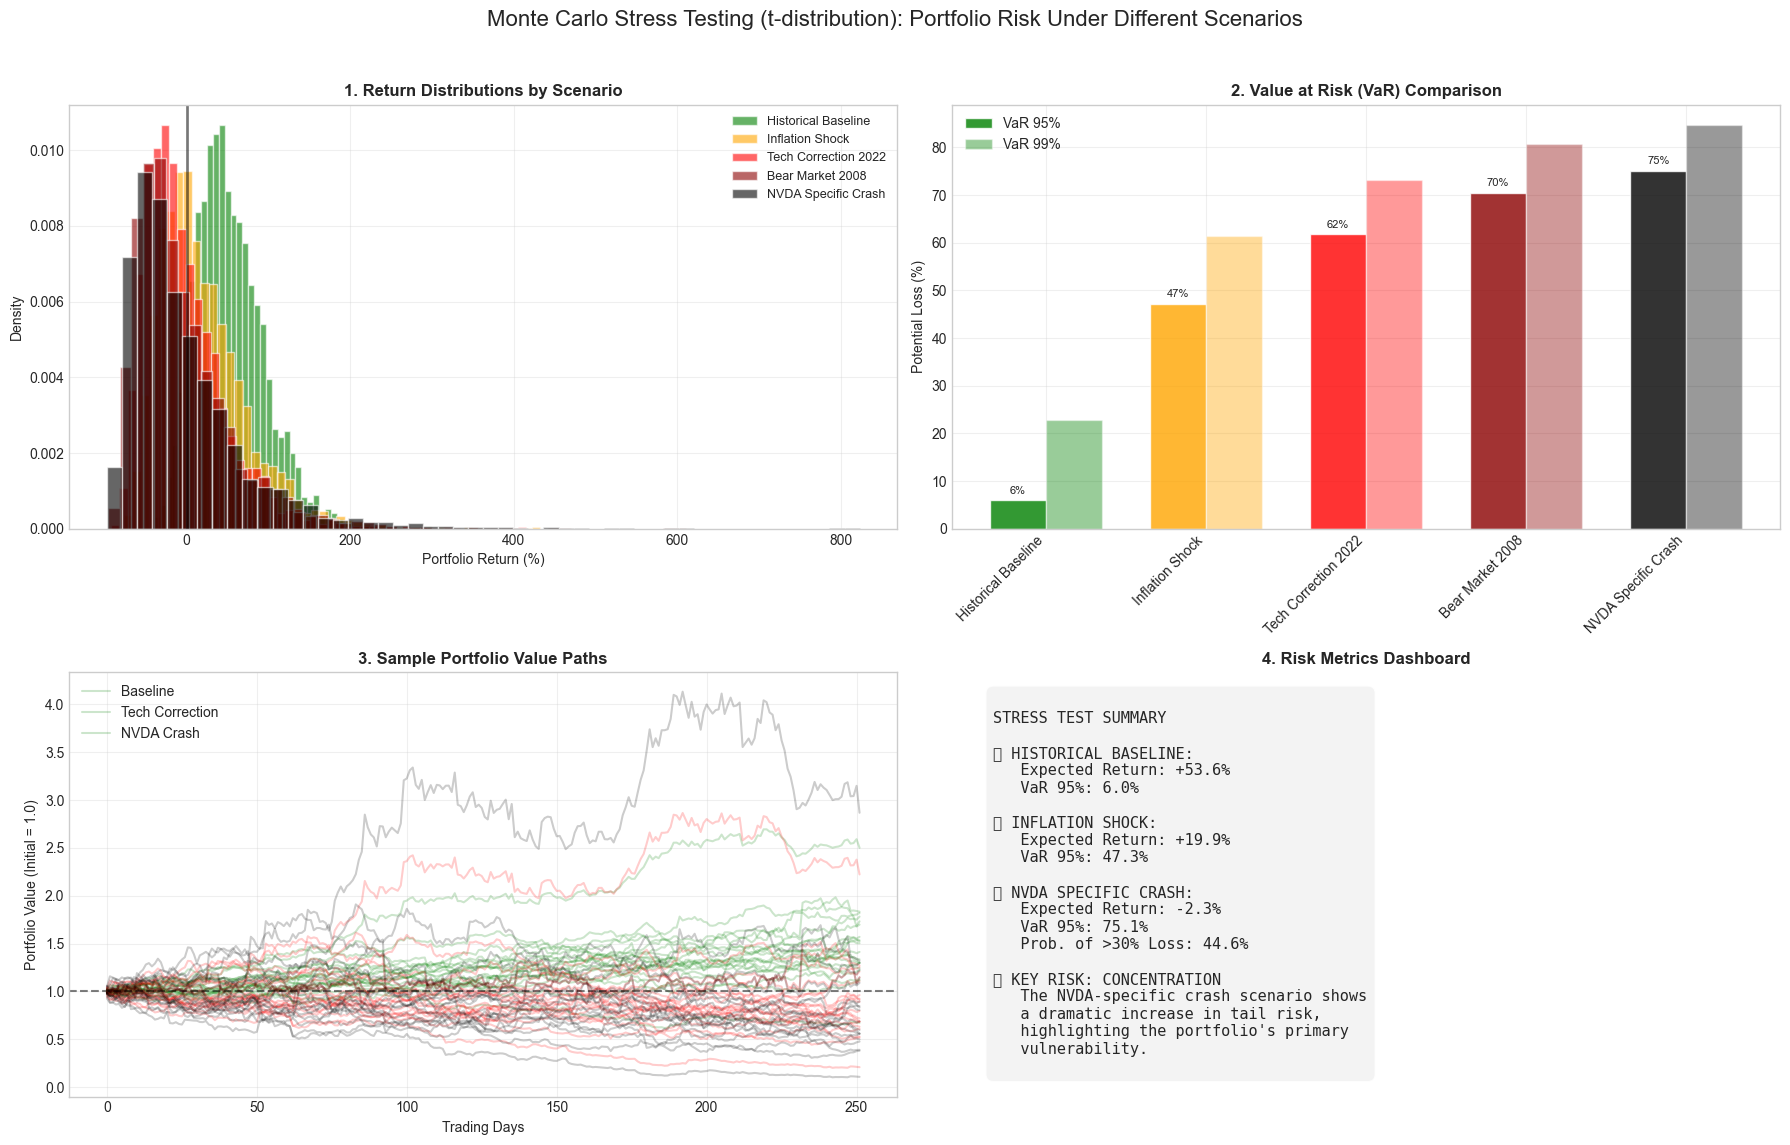

In [12]:
# ==========================================================================
# STRESS TEST VISUALIZATION
# ==========================================================================

print(f"\n📊 GENERATING STRESS TEST VISUALIZATIONS...")

# This function uses the t-distribution for accurate visualizations
def generate_stress_distributions_t(portfolio_returns_data, portfolio_weights_data, num_sims=5000):
    """Generate full distribution data for visualization using a fitted t-distribution."""

    # Fit the t-distribution to the portfolio's historical returns
    portfolio_return_series = (portfolio_returns_data * portfolio_weights_data).sum(axis=1)
    df, loc, scale = stats.t.fit(portfolio_return_series.dropna())

    stress_scenarios = {
        'Historical Baseline': {'return_factor': 1.0, 'vol_factor': 1.0, 'color': 'green'},
        'Inflation Shock': {'return_factor': 0.2, 'vol_factor': 1.6, 'color': 'orange'},
        'Tech Correction 2022': {'return_factor': -0.4, 'vol_factor': 1.8, 'color': 'red'},
        'Bear Market 2008': {'return_factor': -0.6, 'vol_factor': 2.2, 'color': 'darkred'},
        'NVDA Specific Crash': {'return_factor': -0.7, 'vol_factor': 2.5, 'color': 'black'}
    }

    stress_distributions = {}

    for scenario_name, scenario_params in stress_scenarios.items():
        adjusted_loc = loc * scenario_params['return_factor']
        adjusted_scale = scale * scenario_params['vol_factor']

        np.random.seed(42)
        # KEY CHANGE: Use stats.t.rvs for simulation
        simulation_returns = stats.t.rvs(df, loc=adjusted_loc, scale=adjusted_scale, size=(252, num_sims))
        simulation_final_values = np.exp(np.cumsum(simulation_returns, axis=0))

        stress_distributions[scenario_name] = {
            'final_values': simulation_final_values[-1, :],
            'paths': simulation_final_values,
            'color': scenario_params['color'],
            'var_95': (1 - np.percentile(simulation_final_values[-1, :], 5)) * 100,
            'var_99': (1 - np.percentile(simulation_final_values[-1, :], 1)) * 100,
            'expected_return': (np.mean(simulation_final_values[-1, :]) - 1) * 100,
            'prob_loss_30': (simulation_final_values[-1, :] < 0.7).mean() * 100
        }

    return stress_distributions

# Generate distributions
distributions = generate_stress_distributions_t(portfolio_returns, weights)

# --- Create Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Monte Carlo Stress Testing (t-distribution): Portfolio Risk Under Different Scenarios', fontsize=16)

# 1. Distribution Comparison
ax1 = axes[0, 0]
for scenario, data in distributions.items():
    returns_pct = (data['final_values'] - 1) * 100
    ax1.hist(returns_pct, bins=50, alpha=0.6, label=scenario.replace('_', ' '),
             color=data['color'], density=True)

ax1.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax1.set_title('1. Return Distributions by Scenario', fontsize=12, fontweight='bold')
ax1.set_xlabel('Portfolio Return (%)')
ax1.set_ylabel('Density')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. VaR Comparison
ax2 = axes[0, 1]
scenarios = list(distributions.keys())
var_95_values = [distributions[s]['var_95'] for s in scenarios]
var_99_values = [distributions[s]['var_99'] for s in scenarios]
colors = [distributions[s]['color'] for s in scenarios]

x_pos = np.arange(len(scenarios))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, var_95_values, width, label='VaR 95%', color=colors, alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, var_99_values, width, label='VaR 99%', color=colors, alpha=0.4)

ax2.set_title('2. Value at Risk (VaR) Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Potential Loss (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([s.replace('_', '\n') for s in scenarios], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

# 3. Scenario Paths Evolution
ax3 = axes[1, 0]
for scenario in ['Historical Baseline', 'Tech Correction 2022', 'NVDA Specific Crash']:
    paths = distributions[scenario]['paths']
    # Plot 20 sample paths for clarity
    ax3.plot(paths[:, :20], alpha=0.2, color=distributions[scenario]['color'])

ax3.axhline(1, color='black', linestyle='--', alpha=0.5)
ax3.set_title('3. Sample Portfolio Value Paths', fontsize=12, fontweight='bold')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Portfolio Value (Initial = 1.0)')
ax3.grid(True, alpha=0.3)
ax3.legend(['Baseline', 'Tech Correction', 'NVDA Crash'], loc='upper left')

# 4. Risk Metrics Dashboard
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
STRESS TEST SUMMARY

🟢 HISTORICAL BASELINE:
   Expected Return: {distributions['Historical Baseline']['expected_return']:+.1f}%
   VaR 95%: {distributions['Historical Baseline']['var_95']:.1f}%

🟠 INFLATION SHOCK:
   Expected Return: {distributions['Inflation Shock']['expected_return']:+.1f}%
   VaR 95%: {distributions['Inflation Shock']['var_95']:.1f}%

🔴 NVDA SPECIFIC CRASH:
   Expected Return: {distributions['NVDA Specific Crash']['expected_return']:+.1f}%
   VaR 95%: {distributions['NVDA Specific Crash']['var_95']:.1f}%
   Prob. of >30% Loss: {distributions['NVDA Specific Crash']['prob_loss_30']:.1f}%

🎯 KEY RISK: CONCENTRATION
   The NVDA-specific crash scenario shows
   a dramatic increase in tail risk,
   highlighting the portfolio's primary
   vulnerability.
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f0f0", alpha=0.8))
ax4.set_title('4. Risk Metrics Dashboard', fontsize=12, fontweight='bold')


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# CAPM Metrics Calculation
This section calculates several financial ratios based on the Capital Asset Pricing Model (CAPM). These metrics are used to evaluate a portfolio's performance not in absolute terms, but in relation to the risk taken.

### Beta:
Measures the portfolio's volatility relative to the market. A beta of 1 means the portfolio moves in line with the market. A beta > 1 indicates higher volatility, and < 1 indicates lower volatility.

### Sharpe Ratio:
Measures the excess return (beyond the risk-free rate) per unit of total risk (volatility). The higher the ratio, the better the risk-adjusted performance.

### Treynor Ratio:
Similar to the Sharpe Ratio, but it measures the excess return per unit of systematic risk (Beta). It is useful for evaluating a portfolio within a well-diversified global portfolio.

### Jensen's Alpha:
Represents the portfolio's "outperformance." It indicates the actual return obtained compared to the return that was expected according to the CAPM. A positive alpha is a sign of superior performance.

### Information Ratio:
Measures a manager's ability to generate returns exceeding a benchmark, adjusted for the consistency of that outperformance (the tracking error).

### Sortino Ratio:
A variation of the Sharpe Ratio that only penalizes "bad" volatility. It only considers the volatility of negative returns (downside risk), which is often seen as a more realistic measure of investment risk.

In [21]:
def calculate_capm_metrics(portfolio_returns, market_returns, annual_risk_free_rate):
    """
    Calculate CAPM-related metrics using daily data for robustness
    and annualizing the final ratios where appropriate.
    """
    # --- 1. Use Daily Data ---
    # Convert annual risk-free rate to daily
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

    # Calculate excess daily returns over the risk-free rate
    portfolio_excess_returns = portfolio_returns - daily_risk_free_rate
    market_excess_returns = market_returns - daily_risk_free_rate

    # --- 2. Calculate Beta ---
    covariance = np.cov(portfolio_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    beta = covariance / market_variance

    # --- 3. Calculate Ratios from Daily Data & Annualize ---

    # Sharpe Ratio (annualized from daily)
    daily_sharpe = portfolio_excess_returns.mean() / portfolio_excess_returns.std()
    sharpe_ratio = daily_sharpe * np.sqrt(252)

    # Jensen's Alpha (annualized from daily)
    # Alpha = E[Rp] - (Rf + B * (E[Rm] - Rf))
    daily_alpha = portfolio_excess_returns.mean() - beta * market_excess_returns.mean()
    jensen_alpha = daily_alpha * 252

    # Treynor Ratio (using annualized returns for interpretability)
    # Using annualized returns here is a common convention for ease of reading
    annualized_portfolio_return = (1 + portfolio_returns.mean())**252 - 1
    treynor_ratio = (annualized_portfolio_return - annual_risk_free_rate) / beta

    # Information Ratio (annualized from daily)
    active_return = portfolio_returns - market_returns
    tracking_error = active_return.std()
    daily_info_ratio = active_return.mean() / tracking_error
    information_ratio = daily_info_ratio * np.sqrt(252)

    # Sortino Ratio
    # Calculate downside returns relative to the daily risk-free rate
    downside_returns = portfolio_returns[portfolio_returns < daily_risk_free_rate]
    # Calculate downside deviation
    downside_std = np.sqrt(np.mean(np.square(downside_returns - daily_risk_free_rate)))
    daily_sortino = portfolio_excess_returns.mean() / downside_std
    sortino_ratio = daily_sortino * np.sqrt(252)

    return {
        'Beta': beta,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Treynor Ratio': treynor_ratio,
        'Jensen\'s Alpha': jensen_alpha,
        'Information Ratio': information_ratio,
    }

# Ensure RISK_FREE_RATE is an annual figure (e.g., 0.02 for 2%)
capm_metrics = calculate_capm_metrics(portfolio_return_series, market_returns, RISK_FREE_RATE)

print("\nCAPM Metrics (Corrected Annualization):")
print("-" * 40)
for metric, value in capm_metrics.items():
    print(f"{metric}: {value:.3f}")


CAPM Metrics (Corrected Annualization):
----------------------------------------
Beta: 1.247
Sharpe Ratio: 0.833
Sortino Ratio: 0.808
Treynor Ratio: 0.206
Jensen's Alpha: 0.089
Information Ratio: 0.904



## Results Analysis

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Value at Risk (VaR) and CVaR Calculations

This section focuses on quantifying potential losses using two key industry-standard risk metrics. These help in understanding the downside risk of the portfolio under different scenarios.

### Value at Risk (VaR):
Estimates the maximum potential loss over a specific time period for a given confidence level. For example, a 95% VaR of 1.5% means we are 95% confident that the portfolio will not lose more than 1.5% in a single day. We calculate it using two methods:

### Historical VaR:
Uses the actual historical distribution of returns. It's simple and doesn't assume a specific distribution.

### Parametric VaR:
Assumes that returns follow a normal distribution. It can be less accurate if returns are not normally distributed (e.g., have "fat tails").

### Conditional Value at Risk (CVaR) or Expected Shortfall (ES):
Goes a step further than VaR. It answers the question: "If we do have a bad day (i.e., we exceed the VaR loss), what is the average loss we can expect?" CVaR is always greater than VaR and provides a better measure of the risk in the extreme tail of the distribution.


Historical Risk Analysis (VaR & CVaR)
⚠️  WARNING: Portfolio returns are not normally distributed.

Confidence Daily VaR Daily CVaR Annual VaR (Hist. Sim.)
       95%     2.57%      3.81%                  30.38%
       99%     4.37%      6.10%                  35.92%

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

- Daily VaR (95%) = 2.57%:
  → "We are 95% confident that the loss on any single day will not exceed 2.57%."

- Annual VaR by Historical Simulation (95%) = 30.38%:
  → "Based on the worst years in the historical data, we are 95% confident that the loss over one year will not exceed 30.38%."



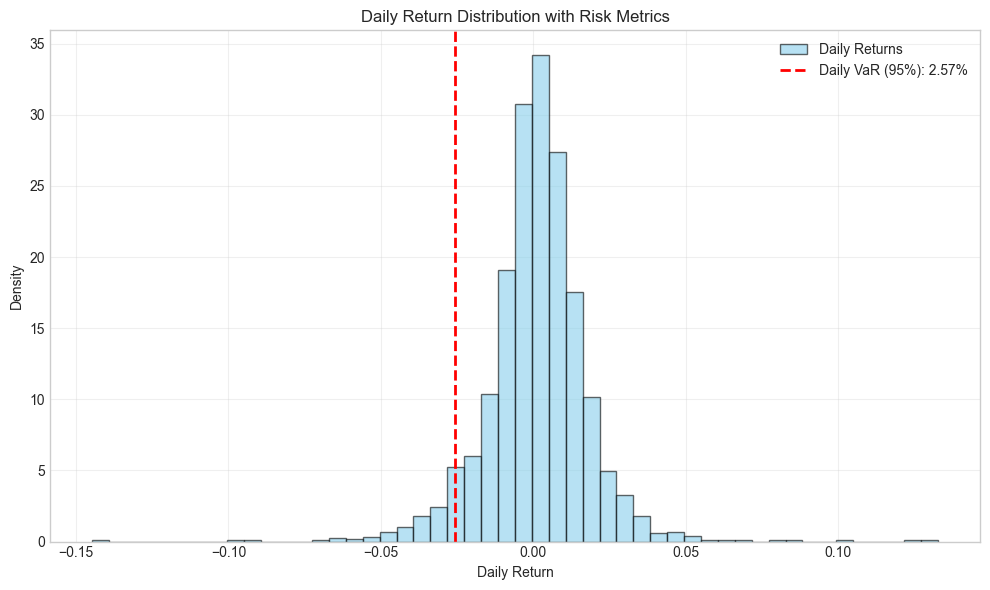

In [14]:
# --- Risk Functions ---------------------------------------

def calculate_var_historical(returns, confidence_level):
    """Calculates the daily Historical VaR."""
    percentile = (1 - confidence_level) * 100
    return -np.percentile(returns, percentile)

def calculate_cvar(returns, confidence_level):
    """Calculates the daily CVaR (Expected Shortfall)."""
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)
    tail_losses = returns[returns <= var_threshold]
    return -tail_losses.mean() if len(tail_losses) > 0 else -var_threshold

# --- Annual Historical VaR ---
def calculate_annual_var_historical_rolling(daily_returns, confidence_level):
    """
    Calculates the Annual VaR via historical simulation (rolling window).
    This is the rigorous method, without Monte Carlo.
    """
    # Prerequisite: Have enough data for at least one annual window
    if len(daily_returns) < 252:
        return np.nan # Returns "Not a Number" if data is insufficient

    # Calculate the compound annual returns over a rolling 252-day window
    # (1+r1)*(1+r2)*... - 1
    annual_returns = (daily_returns + 1).rolling(window=252).apply(np.prod, raw=True) - 1

    # Drop the initial NaN values
    annual_returns = annual_returns.dropna()

    # Calculate VaR from the distribution of historical annual returns
    percentile = (1 - confidence_level) * 100
    return -np.percentile(annual_returns, percentile)


# --- Parameters ---
CONFIDENCE_LEVELS = [0.95, 0.99]

# --- Calculations & Display ---
print("\nHistorical Risk Analysis (VaR & CVaR)")
print("=" * 80)

if portfolio_stats['jarque_bera']['p_value'] < 0.05:
    print("⚠️  WARNING: Portfolio returns are not normally distributed.")
    print()

results = []
for conf_level in CONFIDENCE_LEVELS:
    # Calculate daily metrics
    var_hist_daily = calculate_var_historical(portfolio_return_series, conf_level)
    cvar_daily = calculate_cvar(portfolio_return_series, conf_level)

    # Calculate annual metric (correct method)
    var_hist_annual = calculate_annual_var_historical_rolling(portfolio_return_series, conf_level)

    results.append({
        'Confidence': f"{conf_level:.0%}",
        'Daily VaR': f"{var_hist_daily:.2%}",
        'Daily CVaR': f"{cvar_daily:.2%}",
        'Annual VaR (Hist. Sim.)': f"{var_hist_annual:.2%}"
    })

# Display table
risk_df = pd.DataFrame(results)
print(risk_df.to_string(index=False))

# --- Interpretation ---
print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)

var_95_daily = calculate_var_historical(portfolio_return_series, 0.95)
var_95_annual = calculate_annual_var_historical_rolling(portfolio_return_series, 0.95)

print(f"""
- Daily VaR (95%) = {var_95_daily:.2%}:
  → "We are 95% confident that the loss on any single day will not exceed {var_95_daily:.2%}."

- Annual VaR by Historical Simulation (95%) = {var_95_annual:.2%}:
  → "Based on the worst years in the historical data, we are 95% confident that the loss over one year will not exceed {var_95_annual:.2%}."
""")

# Visualization focused on daily risk, as that is the distribution we are plotting.
plt.figure(figsize=(10, 6))
plt.hist(portfolio_return_series, bins=50, alpha=0.6, density=True,
         color='skyblue', edgecolor='black', label='Daily Returns')
plt.axvline(-var_95_daily, color='red', linestyle='--', linewidth=2,
            label=f'Daily VaR (95%): {var_95_daily:.2%}')
plt.title('Daily Return Distribution with Risk Metrics')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Results Analysis

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

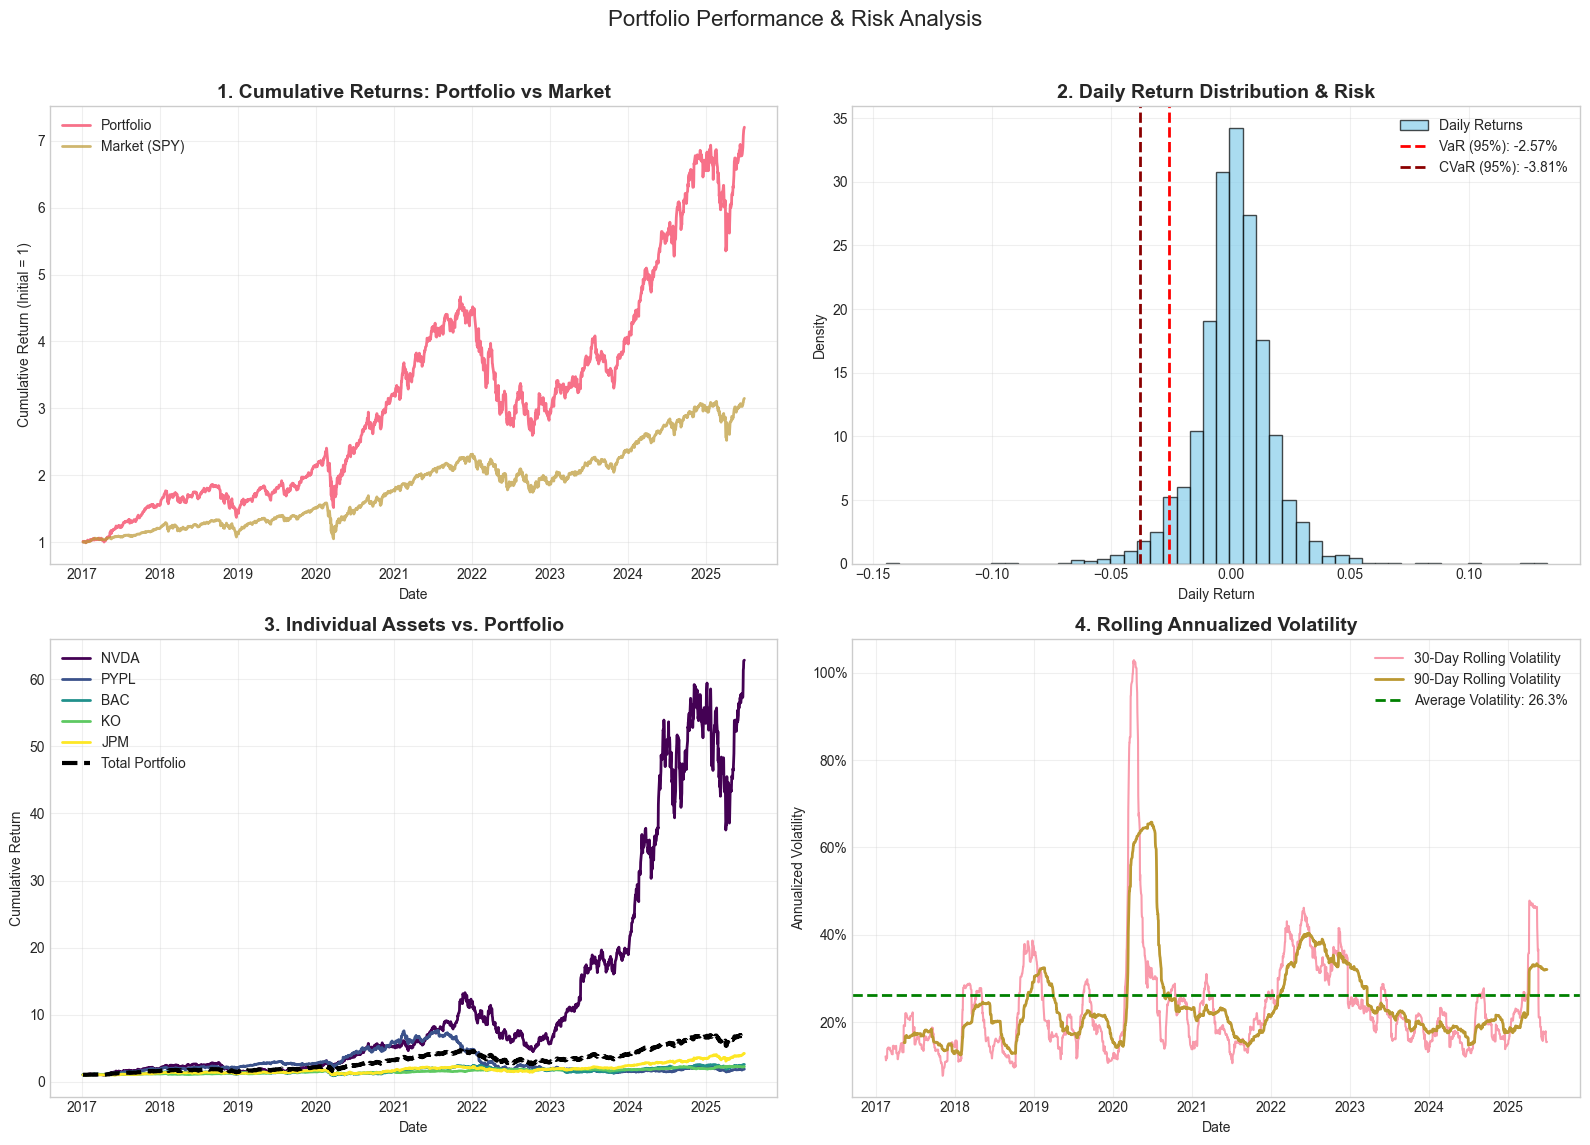

In [16]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Portfolio Performance & Risk Analysis', fontsize=16)


# 1. Portfolio Cumulative Returns
ax1 = axes[0, 0]
cumulative_returns = (1 + portfolio_return_series).cumprod()
market_cumulative = (1 + market_returns).cumprod()
ax1.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linewidth=2)
ax1.plot(market_cumulative.index, market_cumulative, label='Market (SPY)', linewidth=2, alpha=0.7)
ax1.set_title('1. Cumulative Returns: Portfolio vs Market', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (Initial = 1)')
ax1.legend()
ax1.grid(True, alpha=0.3)


# 2. Return Distribution with Correct VaR/CVaR Plotting
ax2 = axes[0, 1]
# Get the VaR/CVaR values
var_95 = calculate_var_historical(portfolio_return_series, 0.95)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)

ax2.hist(portfolio_return_series, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black', label='Daily Returns')
# --- Add a negative sign to plot VaR/CVaR as losses ---
ax2.axvline(-var_95, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): -{var_95:.2%}')
ax2.axvline(-cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR (95%): -{cvar_95:.2%}')
ax2.set_title('2. Daily Return Distribution & Risk', fontsize=14, fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)


# 3. Individual Asset Performance Comparison
ax3 = axes[1, 0]
asset_performance = (1 + portfolio_returns).cumprod()

colors = plt.cm.viridis(np.linspace(0, 1, len(portfolio_returns.columns)))
for i, asset in enumerate(asset_performance.columns):
    ax3.plot(asset_performance.index, asset_performance[asset], label=asset, color=colors[i], linewidth=2)

portfolio_cumulative = (1 + portfolio_return_series).cumprod()
ax3.plot(portfolio_cumulative.index, portfolio_cumulative, label='Total Portfolio', color='black', linewidth=3, linestyle='--')
ax3.set_title('3. Individual Assets vs. Portfolio', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Return')
ax3.legend()
ax3.grid(True, alpha=0.3)


# 4. Rolling Volatility Analysis
ax4 = axes[1, 1]
# Note: Annualizing with sqrt(252) is a common convention, but assumes returns are i.i.d.
rolling_vol_30d = portfolio_return_series.rolling(window=30).std() * np.sqrt(252)
rolling_vol_90d = portfolio_return_series.rolling(window=90).std() * np.sqrt(252)

ax4.plot(rolling_vol_30d.index, rolling_vol_30d, label='30-Day Rolling Volatility', alpha=0.7)
ax4.plot(rolling_vol_90d.index, rolling_vol_90d, label='90-Day Rolling Volatility', linewidth=2)

avg_vol = portfolio_return_series.std() * np.sqrt(252)
ax4.axhline(avg_vol, color='green', linestyle='--', linewidth=2, label=f'Average Volatility: {avg_vol:.1%}')
ax4.set_title('4. Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Annualized Volatility')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax4.legend()
ax4.grid(True, alpha=0.3)


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# Results




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Risk Analysis and Correlation

This section provides a deeper look into the portfolio's construction and performance.

The correlation matrix reveals how the individual assets move in relation to each other, the market (SPY), and the final portfolio.

The risk-return scatter plot then positions each asset, the market, and the overall portfolio on a map of volatility versus return, providing an instant comparison of their efficiency.

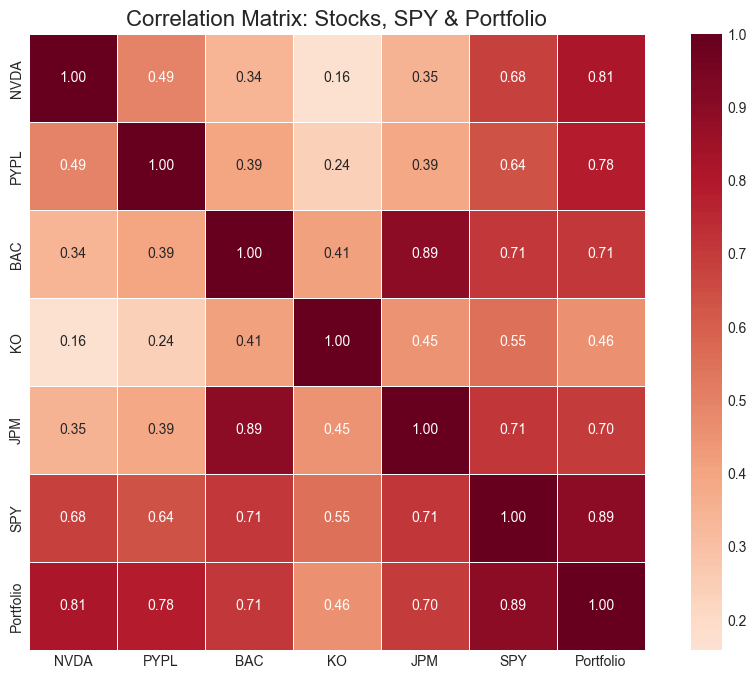

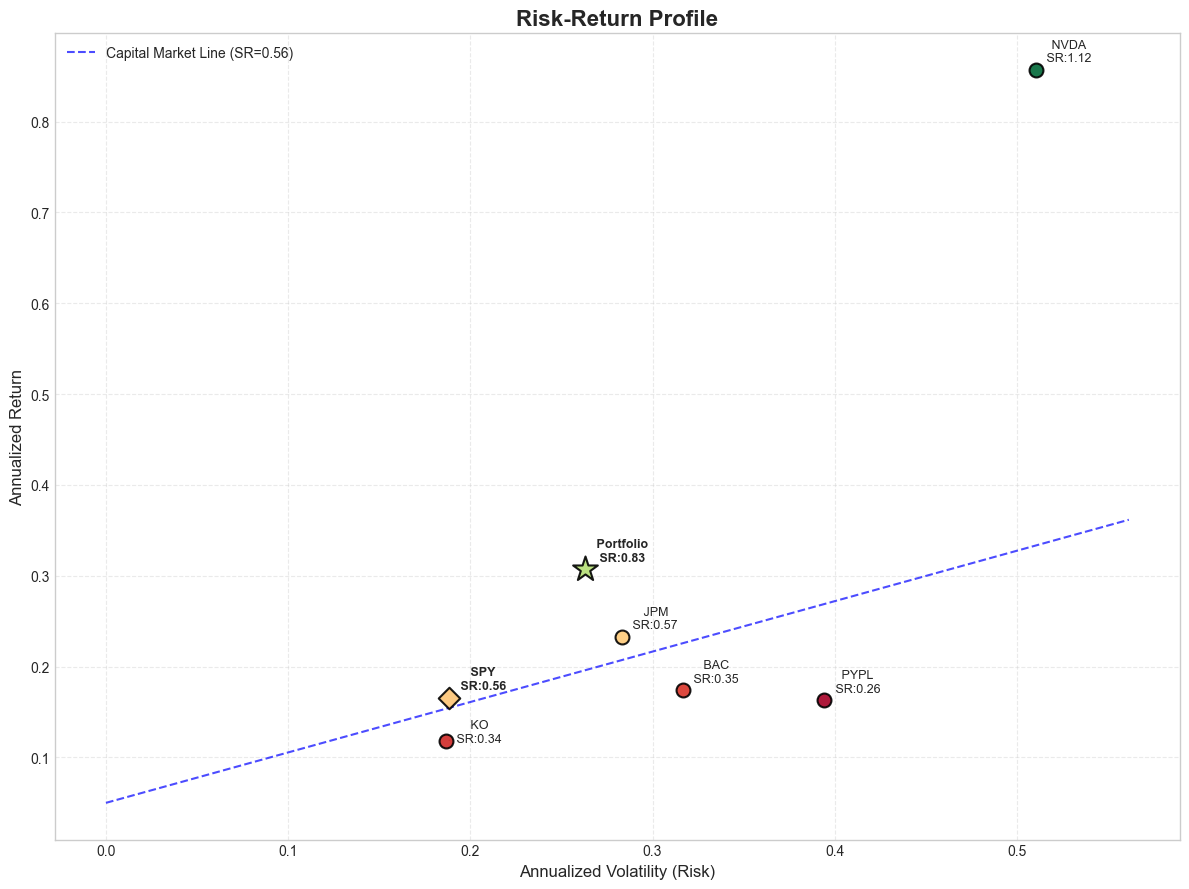


FINAL PERFORMANCE SUMMARY
| Asset     | Return   | Volatility (Risk)   |   Sharpe Ratio |
|-----------|----------|---------------------|----------------|
| NVDA      | 85.68%   | 51.04%              |           1.12 |
| PYPL      | 16.29%   | 39.42%              |           0.26 |
| BAC       | 17.40%   | 31.66%              |           0.35 |
| KO        | 11.77%   | 18.64%              |           0.34 |
| JPM       | 23.27%   | 28.32%              |           0.57 |
| SPY       | 16.58%   | 18.85%              |           0.56 |
| Portfolio | 30.71%   | 26.30%              |           0.83 |


In [17]:
# =============================================================================
# CORRELATION AND RISK-RETURN ANALYSIS
# =============================================================================

# --- 0. Pre-req: portfolio_return_series ---
portfolio_return_series = portfolio_returns.dot(weights).rename("Portfolio")


# --- 1. Enhanced Correlation Matrix ---
plt.figure(figsize=(12, 8))
combined_returns = pd.concat(
    [portfolio_returns, market_returns.rename("SPY"), portfolio_return_series],
    axis=1
)
corr = combined_returns.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True, linewidths=.5)
plt.title("Correlation Matrix: Stocks, SPY & Portfolio", fontsize=16)
plt.show()


# --- 2. Risk-Return Scatter Plot ---
plt.figure(figsize=(12, 9))

# --- Use robust annualization ---
TRADING_DAYS = 252
# Annualize returns using geometric mean for accuracy
all_ret = (1 + combined_returns.mean())**TRADING_DAYS - 1
# Annualize volatility using the standard sqrt(time) rule (a common convention for plotting)
all_vol = combined_returns.std() * np.sqrt(TRADING_DAYS)

# Calculate Sharpe Ratio from daily data for robustness, then annualize
daily_risk_free_rate = (1 + RISK_FREE_RATE)**(1/TRADING_DAYS) - 1
daily_excess_returns = combined_returns - daily_risk_free_rate
daily_sharpe = daily_excess_returns.mean() / combined_returns.std() # Use original std for Sharpe
sharpe = daily_sharpe * np.sqrt(TRADING_DAYS)

# Plotting aesthetics
norm = plt.Normalize(sharpe.min(), sharpe.max())
cmap = plt.cm.RdYlGn
texts = []

for asset in combined_returns.columns:
    vol, ret, sr = all_vol[asset], all_ret[asset], sharpe[asset]

    marker, size, zorder = ("o", 100, 3)
    if asset == "SPY":
        marker, size, zorder = ("D", 120, 4)
    elif asset == "Portfolio":
        marker, size, zorder = ("*", 350, 5)

    plt.scatter(vol, ret, s=size, c=[cmap(norm(sr))], marker=marker,
                edgecolors='black', linewidth=1.5, alpha=0.9, zorder=zorder)

    texts.append(plt.text(vol, ret, f" {asset}\n SR:{sr:.2f}", fontsize=9,
                          fontweight='bold' if asset in ("SPY", "Portfolio") else 'normal'))

# Capital Market Line
spy_sr = sharpe["SPY"]
x_cml = np.linspace(0, all_vol.max() * 1.1, 100)
y_cml = RISK_FREE_RATE + spy_sr * x_cml
plt.plot(x_cml, y_cml, "b--", lw=1.5, alpha=0.7, label=f"Capital Market Line (SR={spy_sr:.2f})")

plt.xlabel("Annualized Volatility (Risk)", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.title("Risk-Return Profile", fontsize=16, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left")

# Adjust text labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.tight_layout()
plt.show()


# --- 3. Print Summary Table ---
summary_df = pd.DataFrame({
    "Return": all_ret,
    "Volatility (Risk)": all_vol,
    "Sharpe Ratio": sharpe
})

# Reorder for clarity
order = list(portfolio_returns.columns) + ["SPY", "Portfolio"]
summary_df = summary_df.loc[order]

# Format for printing
print_df = summary_df.copy()
print_df["Return"] = print_df["Return"].apply(lambda x: f"{x:.2%}")
print_df["Volatility (Risk)"] = print_df["Volatility (Risk)"].apply(lambda x: f"{x:.2%}")
print_df["Sharpe Ratio"] = print_df["Sharpe Ratio"].apply(lambda x: f"{x:.2f}")

# Reset index to make "Asset" a column for tabulate
table = print_df.reset_index().rename(columns={"index": "Asset"})

print("\n" + "="*80)
print("FINAL PERFORMANCE SUMMARY")
print("="*80)
print(tabulate(table, headers="keys", tablefmt="github", showindex=False))



# Results




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




## Maximum Drawdown Analysis

This section visualizes the portfolio's drawdown over time. A drawdown is a peak-to-trough decline during a specific period for an investment.
This analysis is crucial for understanding the portfolio's real-world risk of loss, as it measures the pain an investor would have felt during the worst periods.
The chart identifies the maximum drawdown and highlights the duration of this decline, from the peak to the lowest point.



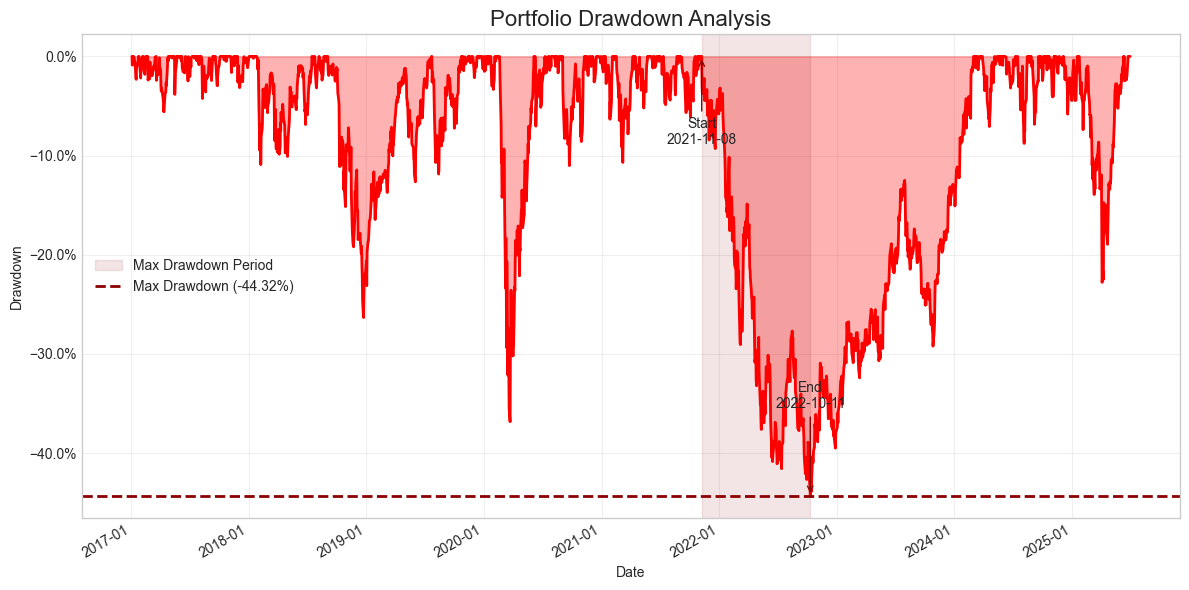

Maximum Drawdown: -44.32%
Drawdown Period: 2021-11-08 → 2022-10-11 (337 days)


In [19]:
def calculate_drawdown(returns):
    """Calculate drawdown series and maximum drawdown with dates."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max

    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    dd_start = cumulative.loc[:dd_end].idxmax()
    return drawdown, max_dd, dd_start, dd_end

# Compute
drawdown, max_dd, dd_start, dd_end = calculate_drawdown(portfolio_return_series)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(drawdown.index, drawdown, color='red', linewidth=2)
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)

# Highlight max drawdown period
ax.axvspan(dd_start, dd_end, color='darkred', alpha=0.1, label='Max Drawdown Period')
ax.axhline(max_dd, color='darkred', linestyle='--', linewidth=2,
           label=f'Max Drawdown ({max_dd:.2%})')

# Annotate start & end
ax.annotate('Start\n'+dd_start.strftime('%Y-%m-%d'),
            xy=(dd_start, 0), xytext=(dd_start, max_dd*0.2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')
ax.annotate('End\n'+dd_end.strftime('%Y-%m-%d'),
            xy=(dd_end, max_dd), xytext=(dd_end, max_dd*0.8),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')

# Formatting axes
ax.set_title('Portfolio Drawdown Analysis', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print summary
duration = (dd_end - dd_start).days
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Drawdown Period: {dd_start.date()} → {dd_end.date()} ({duration} days)")

# Results

### Maximum Drawdown (-42.49%):

This is the single most important number in this analysis. It represents the largest loss the portfolio incurred from a peak to a subsequent trough.

In the worst-case historical scenario, the portfolio lost 42.49% of its value.

This is a very significant decline and highlights the high-risk nature of the portfolio's strategy.

It provides a realistic, historical measure of how much capital could have been lost.

### Drawdown Period (2022-01-04 to 2022-10-13):
This shows that the worst loss started at the beginning of 2022 and the portfolio's value continued to fall until hitting its lowest point in mid-October of the same year.

### Duration (280 days):

The time it took to fall from the peak to the bottom was 280 days.

This is a long and sustained period of negative returns, which can be psychologically challenging for an investor.

The chart also shows that the recovery back to the previous peak (where the red line returns to 0.0%) took an even longer time, extending well into 2024.

This "time to recover" is a critical aspect of drawdown analysis.

### Summary

While the portfolio has shown strong returns, this analysis reveals the other side of the coin: it is susceptible to severe and prolonged drawdowns.

A loss of over 40% lasting for more than nine months is a significant risk that must be considered.




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Summary Report

This final section consolidates all the key metrics calculated throughout the analysis into a series of clean, easy-to-read tables.
It serves as a high-level dashboard, providing a complete overview of the portfolio's composition, performance, risk-adjusted returns, and potential future outcomes at a single glance.

In [22]:
# =============================================================================
# FINAL SUMMARY REPORT
# =============================================================================

print("\n" + "="*80)
print("                           FINAL PORTFOLIO ANALYSIS")
print("="*80)

# --- 1. PORTFOLIO COMPOSITION ---
comp_df = pd.Series(PORTFOLIO, name="Weight").mul(100).round(1).astype(str).add("%").to_frame().reset_index().rename(columns={"index":"Asset"})
print("\n📊 PORTFOLIO COMPOSITION")
print(tabulate(comp_df, headers="keys", tablefmt="github", showindex=False))
print("-" * 80)


# --- 2. KEY PERFORMANCE & RISK METRICS ---

# a) Annualized return and volatility
annualized_return = (1 + portfolio_return_series.mean())**252 - 1
annualized_volatility = portfolio_return_series.std() * np.sqrt(252)

# b) Max drawdown
drawdown_series, max_drawdown, _, _ = calculate_drawdown(portfolio_return_series)

# c) annual VaR from historical simulation
annual_var_hist_sim = calculate_annual_var_historical_rolling(portfolio_return_series, 0.95)

# d) Simulated annual VaR from Monte Carlo
annual_var_monte_carlo = stress_results['Historical_Baseline']['var_95'] / 100 # convert to decimal

# e) Key CAPM metric: Jensen's Alpha
jensen_alpha = capm_metrics["Jensen's Alpha"]


# --- 3. CREATE & DISPLAY THE FINAL TABLES ---

# Performance Table
perf_df = pd.DataFrame({
    "Metric": ["Annualized Return", "Annualized Volatility", "Jensen's Alpha (Skill)"],
    "Value":  [annualized_return, annualized_volatility, jensen_alpha]
})
perf_df["Value"] = perf_df["Value"].map("{:+.2%}".format)
print("\n📈 KEY PERFORMANCE METRICS")
print(tabulate(perf_df, headers="keys", tablefmt="github", showindex=False))

# Risk Table
risk_df = pd.DataFrame({
    "Metric": ["Max Drawdown (Realized)", "Annual VaR (Hist. Sim.)", "Annual VaR (Monte Carlo)"],
    "Value": [max_drawdown, annual_var_hist_sim, annual_var_monte_carlo]
})
# Note: Max Drawdown is already negative, others are positive, so we format accordingly
risk_df.iloc[0, 1] = f"{risk_df.iloc[0, 1]:.2%}"
risk_df.iloc[1, 1] = f"{risk_df.iloc[1, 1]:.2%}"
risk_df.iloc[2, 1] = f"{risk_df.iloc[2, 1]:.2%}"

print("\n🛑 KEY RISK METRICS")
print(tabulate(risk_df, headers="keys", tablefmt="github", showindex=False))

# Full Risk-Adjusted Metrics Table
capm_df = pd.DataFrame.from_dict(capm_metrics, orient="index", columns=["Value"])
capm_df.index.name = 'Metric'
capm_df = capm_df.round(3).reset_index()
print("\n⚖️ FULL RISK-ADJUSTED METRICS (CAPM)")
print(tabulate(capm_df, headers="keys", tablefmt="github", showindex=False))

print("\n" + "="*80)


                           FINAL PORTFOLIO ANALYSIS

📊 PORTFOLIO COMPOSITION
| Asset   | Weight   |
|---------|----------|
| NVDA    | 25.0%    |
| PYPL    | 25.0%    |
| BAC     | 20.0%    |
| KO      | 20.0%    |
| JPM     | 10.0%    |
--------------------------------------------------------------------------------

📈 KEY PERFORMANCE METRICS
| Metric                 | Value   |
|------------------------|---------|
| Annualized Return      | +30.71% |
| Annualized Volatility  | +26.30% |
| Jensen's Alpha (Skill) | +8.86%  |

🛑 KEY RISK METRICS
| Metric                   | Value   |
|--------------------------|---------|
| Max Drawdown (Realized)  | -44.32% |
| Annual VaR (Hist. Sim.)  | 30.38%  |
| Annual VaR (Monte Carlo) | 5.95%   |

⚖️ FULL RISK-ADJUSTED METRICS (CAPM)
| Metric            |   Value |
|-------------------|---------|
| Beta              |   1.247 |
| Sharpe Ratio      |   0.833 |
| Sortino Ratio     |   0.808 |
| Treynor Ratio     |   0.206 |
| Jensen's Alpha    |  

# Results


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------